# Image Mask to geometry (WKT) conversion
This notebook will handle converting a grayscale image mask to a WKT geometry



/Users/remicura/Documents/PROJECTS/CENTAUR/DEV/geometry_precision/src/venv_geom_precision/lib/python3.9/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



color in mask image:  64.0 
		polygon extracted: POLYGON ((729 137, 738 139, 750 149, 762 170, 764 186, 756 205, 749 209, 749 219, 743 227, 745 252, 751 265, 750 285, 734 306, 720 308, 708 303, 706 299, 676 297, 672 291, 672 278, 676 269, 683 266, 685 249, 712 152, 718 143, 729 137))

color in mask image:  64.0 
		polygon extracted: POLYGON ((677 301, 685 301, 692 305, 713 304, 722 310, 732 312, 739 325, 739 336, 734 346, 702 385, 692 413, 692 432, 686 447, 686 477, 682 499, 670 517, 657 521, 636 521, 582 506, 578 495, 578 480, 590 461, 608 420, 630 392, 642 359, 666 315, 667 308, 677 301))

color in mask image:  64.0 
		polygon extracted: POLYGON ((572 507, 586 507, 655 526, 665 537, 667 546, 666 564, 643 586, 619 645, 616 704, 609 754, 609 787, 622 825, 622 834, 628 845, 628 868, 625 875, 609 890, 587 899, 571 899, 547 888, 498 884, 488 875, 483 856, 484 822, 494 807, 505 773, 515 716, 542 623, 548 579, 555 562, 557 534, 566 519, 566 512, 572 507))


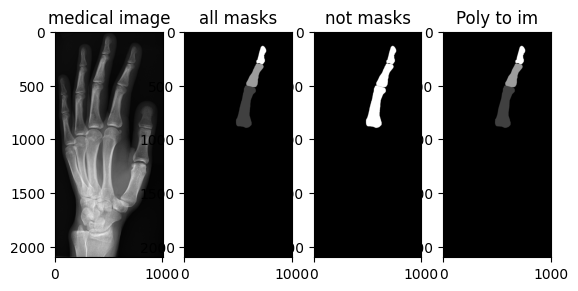

In [81]:
IMAGE_FILE_PATH = './example/input/example_base.png'
IMAGE_MASK_FILE_PATH = './example/input/example_mask.png'
OUTPUT_PATH = f'./example/output/example_mask_wkt.json'

from rasterio import open as open_image
from rasterio.features import shapes as extract_polygons
from rasterio.features import rasterize as polygon_to_image

from shapely.geometry import shape as make_shape
from shapely.validation import make_valid 
from matplotlib import pyplot


medical_image = open_image(IMAGE_FILE_PATH)
mask_image = open_image(IMAGE_MASK_FILE_PATH)
mask_image_first_band = mask_image.read(1) # get first band of image, aka Red. All bands have same value anyway
mask_image_first_band_background = mask_image.read(1) != 0 # ignore background of the mask image

#extract polygons from masks, ignoring background
polygonized_pixels =  extract_polygons(mask_image_first_band ,mask=mask_image_first_band_background 
    , connectivity=8)

polygons = []; mask_colors = [] ; 
for polygon, mask_color in polygonized_pixels: 
    # transform polygon into shapely geometries
    shapely_geom = make_shape(polygon)
    # make sure the geometry is valid 
    shapely_geom_valid = make_valid(shapely_geom)
    # simplify the geometry
    shapely_geom_valid_simplified = shapely_geom_valid.simplify(tolerance=2, preserve_topology=True)
    polygons.append(shapely_geom_valid_simplified)
    mask_colors.append(mask_color)
    print('\ncolor in mask image: ',value, f'\n\t\tpolygon extracted:', shapely_geom_valid_simplified.wkt)

extracted_polygons_to_image = polygon_to_image( list(zip(polygons,mask_colors)) , out_shape=mask_image_first_band.shape)

f, axarr = pyplot.subplots(1,4)
axarr[0].imshow(medical_image.read(1), cmap='gray')           ; axarr[0].set_title('medical image')
axarr[1].imshow(mask_image_first_band, cmap='gray')           ; axarr[1].set_title('all masks')
axarr[2].imshow(mask_image_first_band_background,cmap='gray'); axarr[2].set_title('not masks')
axarr[3].imshow(extracted_polygons_to_image,cmap='gray'); axarr[3].set_title('Poly to im')
pyplot.show()

# @todo: write a csv with 2 columns : | mask_color | wkt | 